# Ein Twitter-Bot für Parteispenden: [@grossspenden](https://twitter.com/grossspenden)

Die Parteien in Deutschland finanzieren sich hauptsächlich aus drei Quellen: aus Beiträgen von Mitgliedern (und i.d.R. Zusatzbeiträgen von Mandatsträgern), staatlichen Zuschüssen, sowie Spenden von Privatpersonen, Unternehmen und Verbänden.

Großspenden, die eine Höhe von 50.000 Euro überschreiten, müssen die Parteien umgehend dem Bundestagspräsidenten anzeigen. Sie werden dann auf [bundestag.de](https://www.bundestag.de/parlament/praesidium/parteienfinanzierung/fundstellen50000/2017/2017-inhalt/488236) veröffentlicht. Dieser Scraper beobachtet die Seite und twittert, wenn eine neue Parteispende bekannt gegeben wird.

An dieser Stelle veröffentliche ich den Quellcode des Scrapers, sodass Außenstehende seine Funktionsweise nachvollziehen können:

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import time
from datetime import datetime
import locale
locale.setlocale(locale.LC_ALL, 'de_DE')

'de_DE'

In [2]:
# read the donation information from the website

url = 'https://www.bundestag.de/parlament/praesidium/parteienfinanzierung/fundstellen50000/2017/2017-inhalt/488236'
response = requests.post(url)
doc = BeautifulSoup(response.text, 'html.parser')

rows = [row for row in doc.tbody.find_all('tr') if row.td.has_attr('colspan') == False]
donations = []

for donation in rows:
    if donation.find_all('td')[4].find('br'):
        date_of_notification = donation.find_all('td')[4].br.previousSibling
    else:
        date_of_notification = donation.find_all('td')[4].text.strip()
    if donation.find_all('td')[2].find('br'):
        donor_name = donation.find_all('td')[2].br.previousSibling.strip()
        lines = [line.nextSibling for line in donation.find_all('td')[2].find_all('br') if line.nextSibling]
        donor_address = ', '.join(lines)
    else:
        donor_name = donation.find_all('td')[2].text.strip()
        donor_address = np.nan
    donations.append({
        'party': donation.find_all('td')[0].text.strip(),
        'amount': float(donation.find_all('td')[1].text.strip().replace('.', '').replace(',', '.')),
        'donor_name': re.sub('^(Herr |Frau |Firma )', '', donor_name),
        'donor_address': donor_address,
        'date_of_receipt': datetime.strptime(donation.find_all('td')[3].text.strip(), '%d.%m.%Y'),
        'date_of_notification': datetime.strptime(date_of_notification, '%d.%m.%Y')
    })

df_new = pd.DataFrame(donations)
df_new

,amount,date_of_notification,date_of_receipt,donor_address,donor_name,party
0,300000.00,2017-06-14,2017-06-14,"Merckstraße 40, 64342 Seeheim-Jugenheim",Prof. Dr. Hans-Joachim Langmann,CDU
1,120563.53,2017-06-08,2017-06-06,Übersetzung: Südschleswig-Ausschuss/Kulturmini...,"Sydslesvigudvalget/ Kulturministeriet, Kulturs...",SSW
2,100000.00,2017-06-06,2017-06-01,"Kurfürstendamm 63, 10707 Berlin",VHB Grundstücksverwaltung und Beteiligung GmbH...,CDU
3,100000.00,2017-05-30,2017-05-29,"Hagrainer Straße 15, 83700 Rottach-Egern",Dr. Georg Kofler,CDU
4,500000.00,2017-05-23,2017-05-23,"Friedensstraße 4, 56410 Montabaur",Ralph Dommermuth,CDU
5,100000.00,2017-05-16,2017-05-16,"Am Weinberg 2, 37115 Duderstadt",Prof. Hans-Georg Näder,FDP
6,100000.00,2017-05-09,2017-05-04,"Neumäuerstraße 39/2, 74523 Schwäbisch Hall",Frank Hansen,Bündnis 90/Die Grünen
7,100000.00,2017-05-03,2017-04-28,70546 Stuttgart,Daimler AG,SPD
8,100000.00,2017-05-02,2017-04-27,70546 Stuttgart,Daimler AG,CDU
9,100000.00,2017-04-11,2017-04-10,"Johann-Maus-Straße 2, 71254 Ditzingen",TRUMPF GmbH + Co. KG,CDU


In [3]:
# prepare tweet functionality

def twitter_api(tweet):
    cfg = { 
        'consumer_key'       : 'XXXXXXXXXXXXXXXXXXXXXXXXXXXX',
        'consumer_secret'    : 'XXXXXXXXXXXXXXXXXXXXXXXXXXXX',
        'access_token'       : 'XXXXXXXXXXXXXXXXXXXXXXXXXXXX',
        'access_token_secret': 'XXXXXXXXXXXXXXXXXXXXXXXXXXXX'
    }
    auth = tweepy.OAuthHandler(cfg['consumer_key'], cfg['consumer_secret'])
    auth.set_access_token(cfg['access_token'], cfg['access_token_secret'])
    status = tweepy.API(auth).update_status(status=tweet)

def tweet(row):
    party = 'bekam die ' + row['party']
    if row['party'] == 'Bündnis 90/Die Grünen':
        party = 'bekamen die Grünen'
    elif row['party'] == 'SSW':
        party = 'bekam der SSW'
    elif row['party'] == 'Die Linke' or row['party'] == 'DIE LINKE.':
        party = 'bekam die Linke'
    date = datetime.strftime(row['date_of_receipt'], '%d. %B')
    if date[0] == '0':
        date = date[1:]
    amount = locale.format('%d', round(row['amount']), grouping=True, monetary=True)
    maxlen = 117 - len('Neue Parteispende: Am ' + date + ' ' + party + ' ' + amount + ' Euro von . ')
    if len(row['donor_name']) > maxlen:
        donor = row['donor_name'][0:maxlen] + '…'
    else:
        donor = row['donor_name'] + '.'
    tweet = 'Neue Parteispende: Am ' + date + ' ' + party + ' ' + amount + ' Euro von ' + donor + ' https://www.bundestag.de/parlament/praesidium/parteienfinanzierung/fundstellen50000/2017/2017-inhalt/488236'
    twitter_api(tweet)

In [4]:
# check if the saved dataset is up to date

df_old = pd.read_csv('parteispenden.csv')
df_old['date_of_receipt'] = pd.to_datetime(df_old['date_of_receipt'])
df_old['date_of_notification'] = pd.to_datetime(df_old['date_of_notification'])

if df_new.equals(df_old) == False:
    import tweepy
    merged = df_new.merge(df_old, how='outer', indicator=True)
    merged[merged['_merge'] == 'left_only'].apply(tweet, axis=1)
    df_new.to_csv('parteispenden.csv', index=False)

## Zwischenfazit zum 18.06.2017

In [5]:
# sum

%matplotlib inline

df_new['amount'].sum().round()

2831300.0

In [6]:
# sum for each party

df_new.groupby('party')['amount'].sum().round().sort_values(ascending=False)

party
CDU                      1553535.0
FDP                       716310.0
SSW                       361455.0
SPD                       100000.0
Bündnis 90/Die Grünen     100000.0
Name: amount, dtype: float64

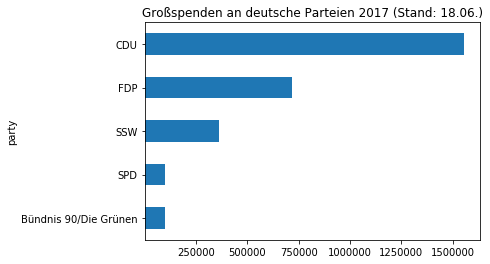

In [7]:
df_new.groupby('party')['amount'].sum().round().sort_values().plot(kind='barh', title='Großspenden an deutsche Parteien 2017 (Stand: 18.06.)', xticks=[250000,500000,750000,1000000,1250000,1500000])